In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [7]:
df = df[(df.ocean_proximity =='<1H OCEAN') | (df.ocean_proximity=='INLAND')]
df.reset_index(drop = True, inplace=True)

In [9]:
df = df.fillna(0)

In [11]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [13]:
y_train= np.log(df_train['median_house_value'])
y_test =np.log( df_test['median_house_value'])
y_val =np.log( df_val['median_house_value'])

X_train = df_train.drop('median_house_value', axis=1)
X_test = df_test.drop('median_house_value', axis=1)
X_val = df_val.drop('median_house_value', axis=1)

In [15]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=True)

train_dict = X_train.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict)
X_val = dv.transform(val_dict)

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
dec_tree = DecisionTreeRegressor(max_depth=1)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
print(export_text(dec_tree, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.30]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24543642958692272

In [23]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rmse))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

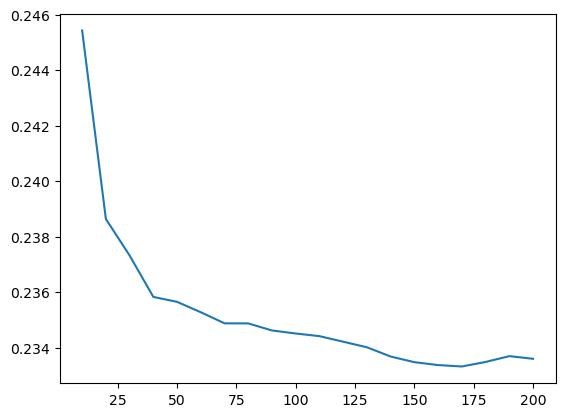

In [24]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [27]:
l = np.array([10, 14, 45, 56])
l.mean()

31.25

In [28]:
scores = []

for md in [10, 15, 20, 25]:
    scr = np.array([])
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scr = np.append(scr, rmse)

    scores.append((n, scr.mean()))
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])

In [29]:
df_scores

,max_depth,rmse
0,200,0.245242
1,200,0.235986
2,200,0.234789
3,200,0.235041


In [30]:
rf_n = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1,n_jobs=-1 )
rf_n.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
df_scr = pd.DataFrame({'features':list(dv.get_feature_names_out()), 'importance': rf_n.feature_importances_})
df_scr.sort_values(by='importance')

,features,importance
5,ocean_proximity=<1H OCEAN,0.000000
0,households,0.015343
8,total_bedrooms,0.015466
9,total_rooms,0.021493
7,population,0.027851
1,housing_median_age,0.030134
3,longitude,0.086834
2,latitude,0.101279
4,median_income,0.335320
6,ocean_proximity=INLAND,0.366280


In [39]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB 163.8 kB/s eta 0:10:09
   ---------------------------------------- 0.0/99.7 MB 178.6 kB/s eta 0:09:19
   ---------------------------------------- 0.1/99.7 MB 262.6 kB/s eta 0:06:20
   ---------------------------------------- 0.1/99.7 MB 308.0 kB/s eta 0:05:24
   ---------------------------------------- 0.1/99.7 MB 426.7 kB/s eta 0:03:54
   ---------------------------------------- 0.2/99

In [40]:
import xgboost as xgb

In [57]:
features = dv.get_feature_names_out()
features = features.tolist()
features[5] = 'ocean_proximity=1H OCEAN'
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [68]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [72]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [70]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [73]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

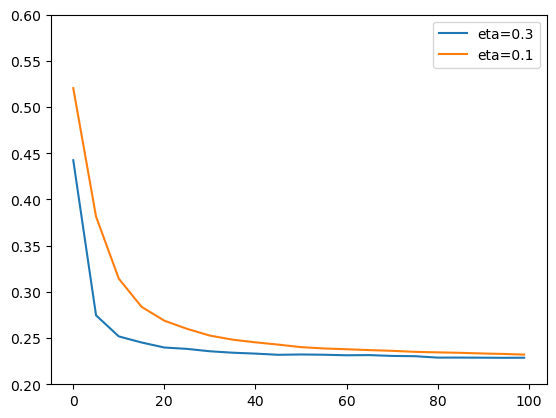

In [76]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.ylim(0.2, 0.6)
plt.legend()